In [1]:
import os
import glob
import pandas as pd
import plotly as py
import cufflinks as cf
import re
%matplotlib inline

### Settings

In [2]:
# Path settings
base_path_to_csv = "/home/till/SharedFolder/trained_models/night-drive/weather_classifier/"

# Settings for epoch selection method
which_mode = "best_eachmetric"  # Options: ["manual", "common", "best_onemetric", "best_eachmetric"]
# epoch to use for mode "common" epoch
epoch_common = 40  # Options: [1, 40]
# metric to use for mode "best_onemetric"
onemetric = "accuracy"  # Options: ['f1_score_weighted', 'f1_score_micro', 'f1_score_macro', 'accuracy', 'roc_auc_micro', 'roc_auc_macro', 'pr_micro', 'pr_macro', 'mcc', 'train_loss', 'train_dev_loss']
# manual list of epochs for mode "manual"
list_selepochs = [[10, 10, 13, 10, 13, 10], # for each trial of run "without_cloudy"
                  [10, 10, 10, 10, 10, 10]] # for each trial of run "with_cloudy"

### Select classifier results

In [3]:
# load results and pick best epochs
# for each run and trial, these results contain a variety of metrics for all epochs for all sub-splits (train, valid, etc)
df_sel = pd.DataFrame()
df_sel_epochs = pd.DataFrame()
df_all = pd.DataFrame()
list_runs = ["without_cloudy", "with_cloudy"]
list_trials = ["train_A_over", "train_B_over", "train_C_over", "train_A_over_ganaug_025", "train_A_over_ganaug_050", "train_B_over_ganaug_025", "train_A_over_ganaug_050_augonlyasbase"]
for r, run in enumerate(list_runs):  # for each set of classifier runs
    for t, trial in enumerate(list_trials):  # for each data set
        path_to_csv = os.path.join(base_path_to_csv,run,trial)
        csv_files = glob.glob(path_to_csv + "/*.csv")
        ### Combine CSVs into one DataFrame ###
        df = pd.DataFrame()
        for csv_file in csv_files:
            df = pd.concat([df, pd.read_csv(csv_file)], axis = 0)
            df = df.reset_index(drop = True)
        ### Some preprocessing ###
        #
        df = df.drop(columns = ["weights"])
        #
        df.data = df.data.apply(lambda x: x.split(os.sep)[-1].split(".json")[0].split("bdd100k_sorted_")[-1])
        df = df.sort_values(by = ["data", "epoch"])
        df = df.reset_index(drop = True)
        ### Load training log file ###
        train_log_file = glob.glob(path_to_csv + "/*.txt")
        assert(len(train_log_file) == 1)
        df_loss = pd.read_csv(train_log_file[0], sep = " ", header = None, skiprows = [0, 1])
        df_loss = df_loss.iloc[:, [1, 3, 7, 11]].rename(columns = {1: "epoch", 3: "batch", 7: "train_loss", 11: "train_dev_loss"})
        df_loss.epoch = df_loss.epoch.apply(lambda x: int(x.split("/")[0]))
        df_loss.batch = df_loss.batch.apply(lambda x: int(x.split("/")[0]))
        df_loss["global_batch"] = (df_loss.epoch - 1) * df_loss.batch.max() + df_loss.batch
        df_loss = df_loss.sort_values(by = ["epoch", "batch"]).set_index("global_batch", drop = True)
        ### Combine loss, scores
        df_combined = df_loss.groupby(by = ["epoch"]).median()
        df_combined = df_combined.drop(columns = ["batch"])
        ### Combine loss, scores into metrics
        # df = df.join(df_combined, on="epoch")
        # stash best results according to selected method
        if which_mode in ["manual", "common"]:
            if which_mode == "manual":  # manual list of epochs, e.g. balancing overfitting and performance
                sel_epoch = list_selepochs[r][t]
            elif which_mode == "common":  # same epoch for every run
                sel_epoch = epoch_common
            rw = df.query("epoch==@sel_epoch").copy()
            rw.loc[:, "trial"] = list_trials[t]
            rw.loc[:, "run"] = list_runs[r]
            df_sel = df_sel.append(rw, ignore_index=True, sort=True) 
        elif which_mode == "best_onemetric":  # for each run, the best epoch accoding to one metric is selected 
            sel_epoch = []
            for subsplit in df.data.unique():
                df_subsplit = df.query("data == @subsplit").copy()
                df_subsplit.reset_index(drop=True, inplace=True)
                rw = df_subsplit.loc[df_subsplit[onemetric].idxmax(), :].to_frame().T
                rw.loc[:, "trial"] = list_trials[t]
                rw.loc[:, "run"] = list_runs[r]
                df_sel = df_sel.append(rw, ignore_index=True, sort=True) 
        elif which_mode == "best_eachmetric":  # all runs and metrics are evaluated independently on their best epoch 
            # find best epoch metric for each metric
            for subsplit in df.data.unique():
                df_subsplit = df.query("data == @subsplit").copy()
                df_subsplit.reset_index(drop=True, inplace=True)
                sel_epochs = df_subsplit.loc[:,df_subsplit.columns[df_subsplit.dtypes == "float64"]].idxmax().to_frame().T
                sel_epochs.loc[:, "trial"] = list_trials[t]
                sel_epochs.loc[:, "run"] = list_runs[r]
                rw = df_subsplit.max().to_frame().T
                rw.loc[:, "trial"] = list_trials[t]
                rw.loc[:, "run"] = list_runs[r]
                df_sel_epochs = df_sel_epochs.append(sel_epochs, ignore_index=True, sort=True) 
                df_sel = df_sel.append(rw, ignore_index=True, sort=True) 

        # stash all data
        df_all = pd.concat([df_all, df], axis=1)

In [4]:
df.head(5)

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,accuracy_balanced,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,test,0.416610,0.357603,0.362211,0.357603,0.507598,0.558730,0.758074,0.418042,0.556142,0.217372
1,2,test,0.617604,0.548325,0.515300,0.548325,0.635635,0.775693,0.860508,0.653937,0.708613,0.354225
2,3,test,0.773570,0.740335,0.637989,0.740335,0.716836,0.897251,0.894623,0.825988,0.769045,0.483436
3,4,test,0.813300,0.795103,0.678030,0.795103,0.735718,0.926422,0.905948,0.873937,0.792658,0.536706
4,5,test,0.811756,0.793814,0.676484,0.793814,0.736812,0.929515,0.910921,0.878833,0.803043,0.535187


In [5]:
df_sel.head(5)

,accuracy,accuracy_balanced,data,epoch,f1_score_macro,f1_score_micro,f1_score_weighted,mcc,pr_macro,pr_micro,roc_auc_macro,roc_auc_micro,run,trial
0,0.89884,NaN,test,40,0.802813,0.89884,0.897838,NaN,0.858218,0.947102,0.932541,0.969566,without_cloudy,train_A_over
1,0.938538,NaN,test_daytime,40,0.910764,0.938538,0.939112,NaN,0.959121,0.980361,0.987219,0.989223,without_cloudy,train_A_over
2,0.873684,NaN,test_night,40,0.675203,0.873684,0.869123,NaN,0.715868,0.918439,0.852201,0.953797,without_cloudy,train_A_over
3,0.923899,NaN,train_dev_A_over,40,0.923793,0.923899,0.923793,NaN,0.972457,0.97368,0.98534,0.985166,without_cloudy,train_A_over
4,0.893041,NaN,valid,40,0.792849,0.893041,0.893142,NaN,0.859847,0.952391,0.941083,0.972414,without_cloudy,train_A_over


In [6]:
# print best epochs for each metric, if available
df_sel_epochs.head(5)

,accuracy,accuracy_balanced,f1_score_macro,f1_score_micro,f1_score_weighted,mcc,pr_macro,pr_micro,roc_auc_macro,roc_auc_micro,run,trial
0,29,NaN,29,29,29,NaN,11,29,24,29,without_cloudy,train_A_over
1,29,NaN,27,29,29,NaN,31,31,31,31,without_cloudy,train_A_over
2,29,NaN,17,29,29,NaN,11,29,10,29,without_cloudy,train_A_over
3,11,NaN,11,11,11,NaN,11,17,11,17,without_cloudy,train_A_over
4,29,NaN,31,29,29,NaN,17,29,11,29,without_cloudy,train_A_over


### Print results for best epochs gouped by split

In [7]:
# Selection (and order) of columns to be printed
meta2print = ["epoch", "trial", "run"]
metrics2print = ['accuracy','f1_score_macro', 'f1_score_micro', 'f1_score_weighted', 'pr_macro', 'pr_micro', 'roc_auc_macro', 'roc_auc_micro']
cols2print = [*meta2print, *metrics2print]
# rename train dev sets
df_sel.data = df_sel.data.apply(lambda x: re.sub(r"_[A-C]_[a-zA-Z0-9_]*", r"", x))

#### Valid-All

In [8]:
split = "valid"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "=== Results for best manual epoch ===")
df_cursplit.loc[:, cols2print].head(df_cursplit.shape[0])


=== valid === Results for best manual epoch ===


,epoch,trial,run,accuracy,f1_score_macro,f1_score_micro,f1_score_weighted,pr_macro,pr_micro,roc_auc_macro,roc_auc_micro
0,40,train_A_over,without_cloudy,0.893041,0.792849,0.893041,0.893142,0.859847,0.952391,0.941083,0.972414
1,40,train_B_over,without_cloudy,0.897552,0.80638,0.897552,0.898291,0.884118,0.958424,0.958963,0.97604
2,40,train_C_over,without_cloudy,0.88982,0.795151,0.88982,0.893128,0.882341,0.95204,0.958734,0.972904
3,40,train_A_over_ganaug_025,without_cloudy,0.88982,0.786326,0.88982,0.890425,0.862335,0.950622,0.945434,0.971908
4,40,train_A_over_ganaug_050,without_cloudy,0.884021,0.786242,0.884021,0.886765,0.857608,0.945428,0.943539,0.968208
5,40,train_B_over_ganaug_025,without_cloudy,0.91366,0.831803,0.91366,0.913302,0.887026,0.962772,0.955279,0.978571
6,40,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.898196,0.795429,0.898196,0.896608,0.853392,0.955286,0.941131,0.974108
7,40,train_A_over,with_cloudy,0.832,0.751538,0.832,0.830636,0.81191,0.886898,0.928633,0.953876
8,40,train_B_over,with_cloudy,0.8395,0.777637,0.8395,0.839658,0.84711,0.900689,0.944144,0.959489
9,40,train_C_over,with_cloudy,0.8285,0.76104,0.8285,0.829755,0.8397,0.894224,0.942749,0.956511


#### Valid-Night

In [9]:
split = "valid_night"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "===")
df_cursplit.loc[:, cols2print].head(df_cursplit.shape[0])


=== valid_night ===


,epoch,trial,run,accuracy,f1_score_macro,f1_score_micro,f1_score_weighted,pr_macro,pr_micro,roc_auc_macro,roc_auc_micro
0,40,train_A_over,without_cloudy,0.875789,0.696724,0.875789,0.874655,0.738081,0.928701,0.875442,0.95854
1,40,train_B_over,without_cloudy,0.887368,0.735891,0.887368,0.888559,0.8094,0.942573,0.924207,0.966657
2,40,train_C_over,without_cloudy,0.876842,0.731714,0.876842,0.883492,0.8238,0.934606,0.933301,0.96331
3,40,train_A_over_ganaug_025,without_cloudy,0.874737,0.690314,0.874737,0.873889,0.742771,0.928244,0.89149,0.959963
4,40,train_A_over_ganaug_050,without_cloudy,0.865263,0.696564,0.865263,0.870254,0.749144,0.922025,0.890358,0.954627
5,40,train_B_over_ganaug_025,without_cloudy,0.909474,0.768124,0.909474,0.905769,0.808342,0.951188,0.913236,0.972194
6,40,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.886316,0.697862,0.886316,0.881217,0.712757,0.93542,0.875675,0.96248
7,40,train_A_over,with_cloudy,0.842,0.632421,0.842,0.83676,0.653646,0.872777,0.844902,0.946179
8,40,train_B_over,with_cloudy,0.866,0.703858,0.866,0.863639,0.745281,0.909754,0.899249,0.960607
9,40,train_C_over,with_cloudy,0.849,0.687554,0.849,0.851635,0.748335,0.901119,0.902795,0.957516


In [10]:
print("\n===", split, "Difference to A ===")
one_half = df_cursplit.shape[0]//2
df_cursplit_diff = df_cursplit.copy()
for col in df_cursplit.columns:
    if not isinstance(df_cursplit.loc[0,col], str):
        df_cursplit_diff.loc[0:one_half-1,col] = df_cursplit_diff.loc[0:one_half-1,col] - df_cursplit.loc[0,col]
        df_cursplit_diff.loc[one_half:one_half*2-1,col] = df_cursplit_diff.loc[one_half:one_half*2-1,col] - df_cursplit.loc[one_half,col]
df_cursplit_diff.loc[:, cols2print].head(df_cursplit_diff.shape[0])


=== valid_night Difference to A ===


,epoch,trial,run,accuracy,f1_score_macro,f1_score_micro,f1_score_weighted,pr_macro,pr_micro,roc_auc_macro,roc_auc_micro
0,0,train_A_over,without_cloudy,0,0,0,0,0,0,0,0
1,0,train_B_over,without_cloudy,0.0115789,0.039167,0.0115789,0.0139038,0.0713189,0.0138724,0.0487642,0.00811662
2,0,train_C_over,without_cloudy,0.00105263,0.03499,0.00105263,0.00883664,0.0857196,0.00590589,0.0578589,0.00476981
3,0,train_A_over_ganaug_025,without_cloudy,-0.00105263,-0.00640987,-0.00105263,-0.000766562,0.00469052,-0.000456094,0.0160482,0.00142216
4,0,train_A_over_ganaug_050,without_cloudy,-0.0105263,-0.000159185,-0.0105263,-0.00440145,0.0110631,-0.00667511,0.0149156,-0.0039133
5,0,train_B_over_ganaug_025,without_cloudy,0.0336842,0.0714004,0.0336842,0.0311136,0.0702615,0.0224871,0.037794,0.013654
6,0,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.0105263,0.00113865,0.0105263,0.0065621,-0.0253236,0.00671985,0.000232271,0.00393934
7,0,train_A_over,with_cloudy,0,0,0,0,0,0,0,0
8,0,train_B_over,with_cloudy,0.024,0.0714373,0.024,0.0268785,0.0916356,0.0369777,0.0543465,0.014428
9,0,train_C_over,with_cloudy,0.007,0.0551333,0.007,0.0148746,0.0946895,0.0283422,0.057893,0.0113373


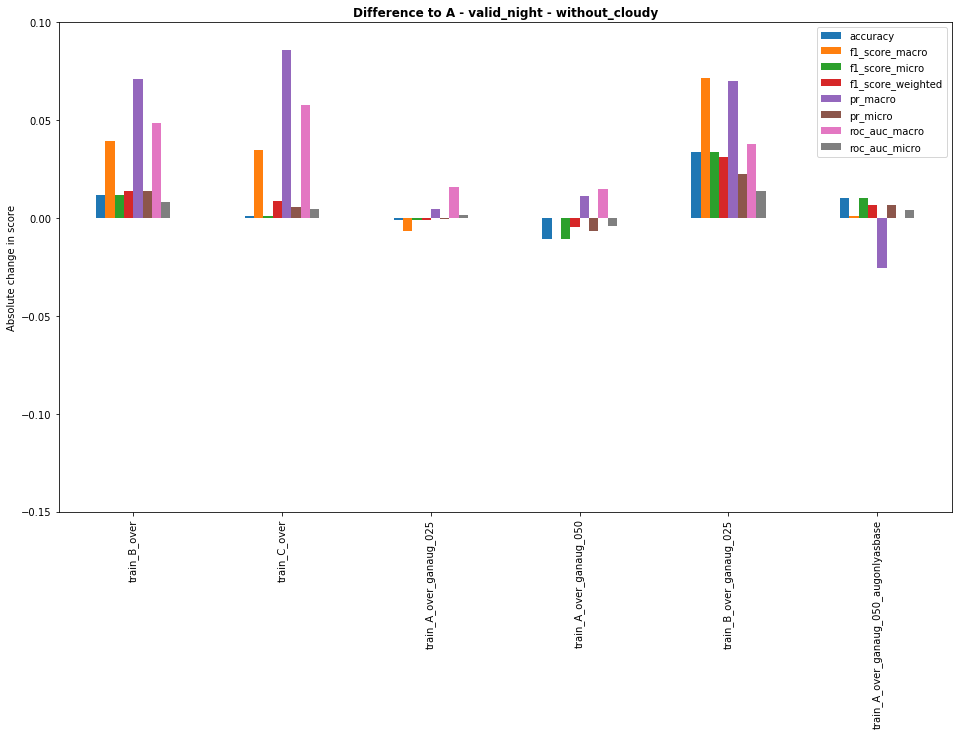

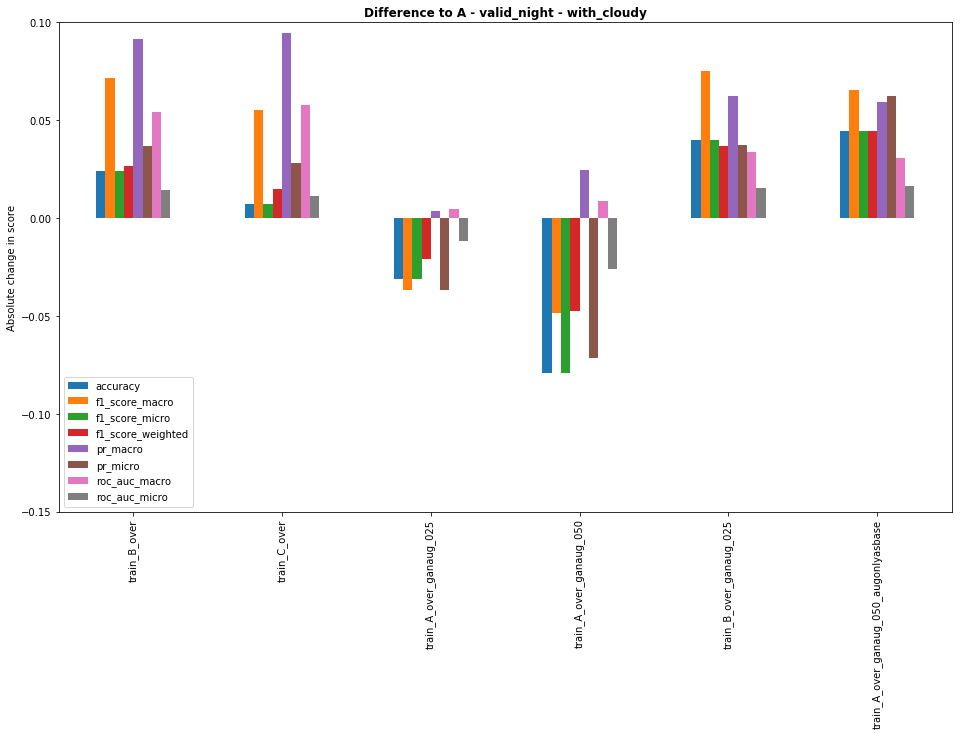

In [11]:
# plot difference
for trial in ["without_cloudy", "with_cloudy"]:
    df_cursplit_plot = df_cursplit_diff.copy()
    df_cursplit_plot = df_cursplit_plot.loc[df_cursplit_diff.run==trial, :].reset_index(drop=True)
    df_cursplit_plot = df_cursplit_plot.loc[1:df_cursplit_plot.shape[0], :]
    ax = df_cursplit_plot.set_index(["trial"]).loc[:, metrics2print].plot(kind = "bar", figsize = (16, 9))
    ax.set_xlabel("")
    ax.set_ylabel("Absolute change in score")
    ax.set_ylim(-0.15, 0.1)
    ax.set_title(f"Difference to A - {split} - {trial}", fontweight="bold")

#### Test-All

In [12]:
split = "test"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "===")
df_cursplit.loc[:, cols2print].head(df_cursplit.shape[0])


=== test ===


,epoch,trial,run,accuracy,f1_score_macro,f1_score_micro,f1_score_weighted,pr_macro,pr_micro,roc_auc_macro,roc_auc_micro
0,40,train_A_over,without_cloudy,0.89884,0.802813,0.89884,0.897838,0.858218,0.947102,0.932541,0.969566
1,40,train_B_over,without_cloudy,0.902706,0.821133,0.902706,0.903748,0.884097,0.953398,0.948269,0.97408
2,40,train_C_over,without_cloudy,0.896263,0.810137,0.896263,0.898562,0.881354,0.950346,0.950204,0.972656
3,40,train_A_over_ganaug_025,without_cloudy,0.885309,0.780963,0.885309,0.88575,0.851916,0.945518,0.935208,0.968476
4,40,train_A_over_ganaug_050,without_cloudy,0.87951,0.780049,0.87951,0.882423,0.850827,0.93894,0.933234,0.965058
5,40,train_B_over_ganaug_025,without_cloudy,0.913015,0.82681,0.913015,0.912103,0.875273,0.955771,0.94443,0.974584
6,40,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.89433,0.800081,0.89433,0.893419,0.852153,0.947709,0.932078,0.969967
7,40,train_A_over,with_cloudy,0.8485,0.777563,0.8485,0.848104,0.835361,0.902181,0.934289,0.959781
8,40,train_B_over,with_cloudy,0.8555,0.793282,0.8555,0.855876,0.847821,0.903067,0.943784,0.962719
9,40,train_C_over,with_cloudy,0.85,0.784015,0.85,0.850954,0.850694,0.90301,0.944129,0.961269


#### Test-Night

In [13]:
split = "test_night"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "===")
df_cursplit.loc[:, cols2print].head(df_cursplit.shape[0])


=== test_night ===


,epoch,trial,run,accuracy,f1_score_macro,f1_score_micro,f1_score_weighted,pr_macro,pr_micro,roc_auc_macro,roc_auc_micro
0,40,train_A_over,without_cloudy,0.873684,0.675203,0.873684,0.869123,0.715868,0.918439,0.852201,0.953797
1,40,train_B_over,without_cloudy,0.888421,0.740417,0.888421,0.889937,0.793323,0.93001,0.897657,0.962739
2,40,train_C_over,without_cloudy,0.877895,0.72287,0.877895,0.882013,0.793724,0.9213,0.901167,0.958787
3,40,train_A_over_ganaug_025,without_cloudy,0.858947,0.657608,0.858947,0.859315,0.720191,0.917585,0.866091,0.953377
4,40,train_A_over_ganaug_050,without_cloudy,0.853684,0.672255,0.853684,0.859214,0.725403,0.90589,0.866516,0.947935
5,40,train_B_over_ganaug_025,without_cloudy,0.906316,0.747082,0.906316,0.901815,0.779434,0.937268,0.890424,0.965219
6,40,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.874737,0.674993,0.874737,0.868902,0.68698,0.916014,0.853229,0.954091
7,40,train_A_over,with_cloudy,0.859,0.657703,0.859,0.852067,0.683847,0.890011,0.850359,0.952225
8,40,train_B_over,with_cloudy,0.867,0.701427,0.867,0.866862,0.749733,0.897958,0.89258,0.959377
9,40,train_C_over,with_cloudy,0.858,0.664078,0.858,0.853619,0.750903,0.897563,0.892326,0.958013


In [14]:
print("\n===", split, "Difference to A ===")
one_half = df_cursplit.shape[0]//2
df_cursplit_diff = df_cursplit.copy()
for col in df_cursplit.columns:
    if not isinstance(df_cursplit.loc[0,col], str):
        df_cursplit_diff.loc[0:one_half-1,col] = df_cursplit_diff.loc[0:one_half-1,col] - df_cursplit.loc[0,col]
        df_cursplit_diff.loc[one_half:one_half*2-1,col] = df_cursplit_diff.loc[one_half:one_half*2-1,col] - df_cursplit.loc[one_half,col]
df_cursplit_diff.loc[:, cols2print].head(df_cursplit_diff.shape[0])


=== test_night Difference to A ===


,epoch,trial,run,accuracy,f1_score_macro,f1_score_micro,f1_score_weighted,pr_macro,pr_micro,roc_auc_macro,roc_auc_micro
0,0,train_A_over,without_cloudy,0,0,0,0,0,0,0,0
1,0,train_B_over,without_cloudy,0.0147368,0.0652143,0.0147368,0.0208137,0.077455,0.0115716,0.0454557,0.00894238
2,0,train_C_over,without_cloudy,0.00421053,0.047667,0.00421053,0.0128893,0.0778563,0.00286151,0.048966,0.00499003
3,0,train_A_over_ganaug_025,without_cloudy,-0.0147368,-0.0175952,-0.0147368,-0.00980871,0.00432308,-0.000853405,0.0138903,-0.000419668
4,0,train_A_over_ganaug_050,without_cloudy,-0.02,-0.00294784,-0.02,-0.00990944,0.00953509,-0.0125489,0.0143153,-0.00586233
5,0,train_B_over_ganaug_025,without_cloudy,0.0326316,0.0718787,0.0326316,0.0326915,0.0635659,0.0188286,0.038223,0.0114219
6,0,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.00105263,-0.00021038,0.00105263,-0.000221146,-0.0288881,-0.00242485,0.00102782,0.000293906
7,0,train_A_over,with_cloudy,0,0,0,0,0,0,0,0
8,0,train_B_over,with_cloudy,0.008,0.0437235,0.008,0.014795,0.0658859,0.00794654,0.0422213,0.00715183
9,0,train_C_over,with_cloudy,-0.001,0.0063744,-0.001,0.00155211,0.0670557,0.00755208,0.0419671,0.0057875


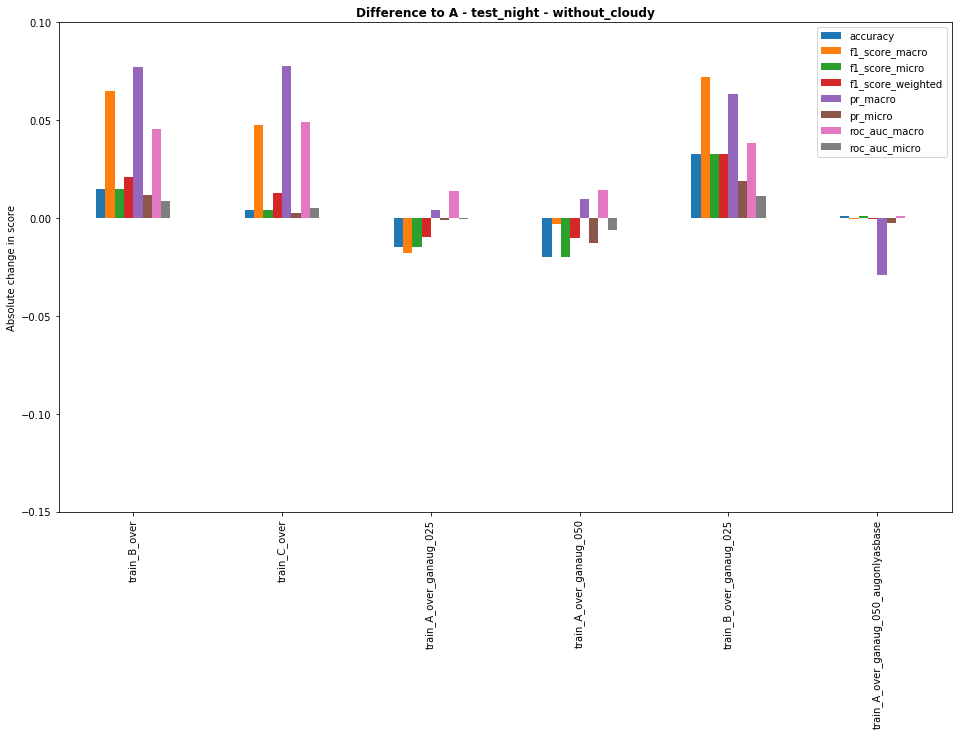

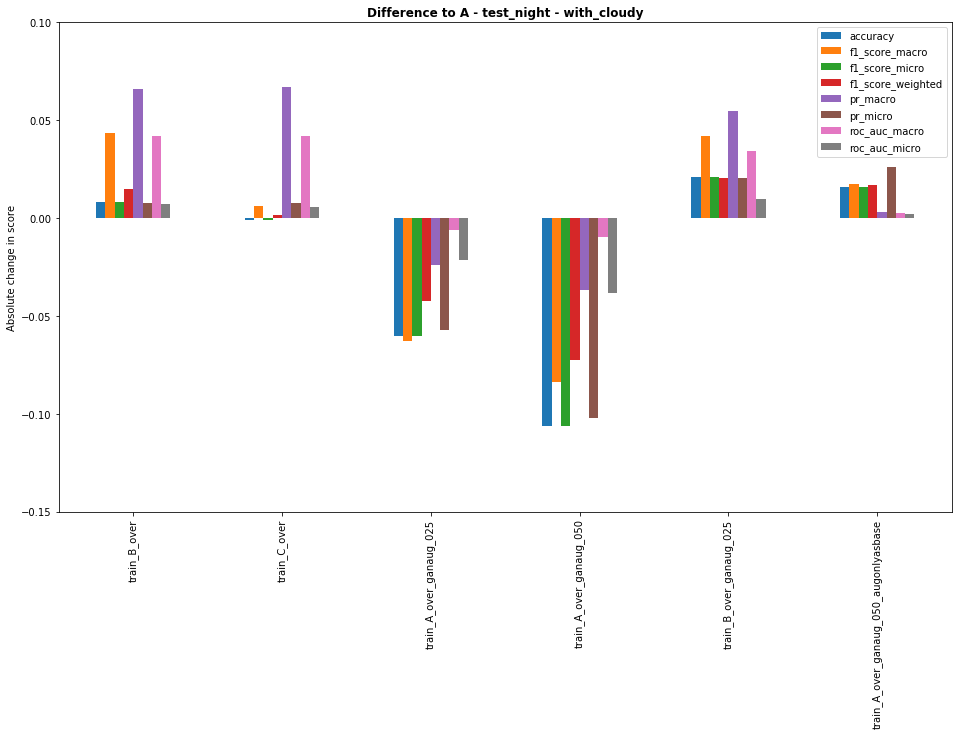

In [15]:
# plot difference
for trial in ["without_cloudy", "with_cloudy"]:
    df_cursplit_plot = df_cursplit_diff.copy()
    df_cursplit_plot = df_cursplit_plot.loc[df_cursplit_diff.run==trial, :].reset_index(drop=True)
    df_cursplit_plot = df_cursplit_plot.loc[1:df_cursplit_plot.shape[0], :]
    ax = df_cursplit_plot.set_index(["trial"]).loc[:, metrics2print].plot(kind = "bar", figsize = (16, 9))
    ax.set_xlabel("")
    ax.set_ylabel("Absolute change in score")
    ax.set_ylim(-0.15, 0.1)
    ax.set_title(f"Difference to A - {split} - {trial}", fontweight="bold")